In [1]:
library(cowplot)
library(tidyverse)
library(magrittr)
library(ggrepel)

results <- '../results/gwas/' 

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.3.0     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ purrr::flatten()  masks jsonlite::flatten()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
exps <- c('t1d', 't2d', 'ra')

lapply(exps, function(e) {
    read_tsv(paste0('../results/gwas/', e, '/', e, '_prediction.tsv'), 
             col_types = 'ciid') %>%
    mutate(model = ifelse(model == 'HSIC_lasso-B=20-M=3, discrete_x = True', 
                          'Block HSIC Lasso, B = 20' , model),
           Phenotype = toupper(e))
}) %>% bind_rows %>%
    group_by(Phenotype, model) %>%
    summarize(ended = sum(!is.na(accuracy)),
              sem = (sd(accuracy, na.rm = T) / ended),
              accuracy = mean(accuracy, na.rm = T) %>% round(digits = 3),
              ci = (1.96 * sem / sqrt(ended)) %>% round(digits = 3), 
              fmt_accuracy = paste(accuracy, '±', ci)) %>%
    select(-accuracy, -sem, -ci, -ended) %>%
    spread(key = model, value = fmt_accuracy)

Phenotype,"Block HSIC Lasso, B = 20",LARS,mRMR,Raw
RA,0.928 ± 0.002,0.915 ± 0.002,0.928 ± 0.001,0.696 ± 0.003
T1D,0.858 ± 0.004,0.854 ± 0.002,0.869 ± 0.004,0.709 ± 0.005
T2D,0.851 ± 0.002,0.822 ± 0.003,0.882 ± 0.002,0.613 ± 0.003


# Selected biomarkers

In [3]:
manhattan <- function(pheno) {
    
    map <- read_tsv('../results/gwas/t1d/controls.bim',
                    col_names = F, col_types = 'iciiii') %>%
           set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
           select(-cm, -x1, -x2)
    
    snp2gene <- read_tsv(paste0(results, 'snp2hgnc.tsv'), 
                     col_types = 'cc')
    
    selected <- read_tsv(paste0(results, pheno, '/', pheno, 
                                '_hsic_lasso_C=50_SELECT=50_M=3_B=20.txt'), 
                     col_names = F, col_types = 'c') %>%
        set_colnames('snp') %>%
        .$snp
    
    gwas <- read_tsv(paste0(results, pheno, '/univariate_association.tsv'), 
                     col_types = 'icidddddd') %>%
            rename(chr = CHR, snp = SNP) %>%
            inner_join(map, by = c('chr', 'snp')) %>%
                mutate(selected = ifelse(snp %in% selected, 'Yes', 'No')) %>%
                arrange(selected)

    don <- gwas %>% 

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # Add a cumulative position of each SNP
      arrange(chr, pos) %>%
      mutate( BPcum=pos+tot) %>%
      left_join(arrange(snp2gene, symbol) %>% group_by(snp) %>% summarize(symbol = head(symbol, 1)), by = 'snp')

    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
        scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(.05/500000), color = 'red') +
    
        # add gene symbols
        geom_text_repel(data = filter(don, selected == 'Yes' & !is.na(symbol)), 
                        aes(x=BPcum, y=-log10(P), label = symbol)) +

        # custom X axis:
        scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_log10(expand = c(0, 0)) +  # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome', y = bquote('-log' [10] ~'(p-value)'))
    
}

In [4]:
t1d_plt <- manhattan('t1d')
t2d_plt <- manhattan('t2d')
ra_plt <- manhattan('ra')

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

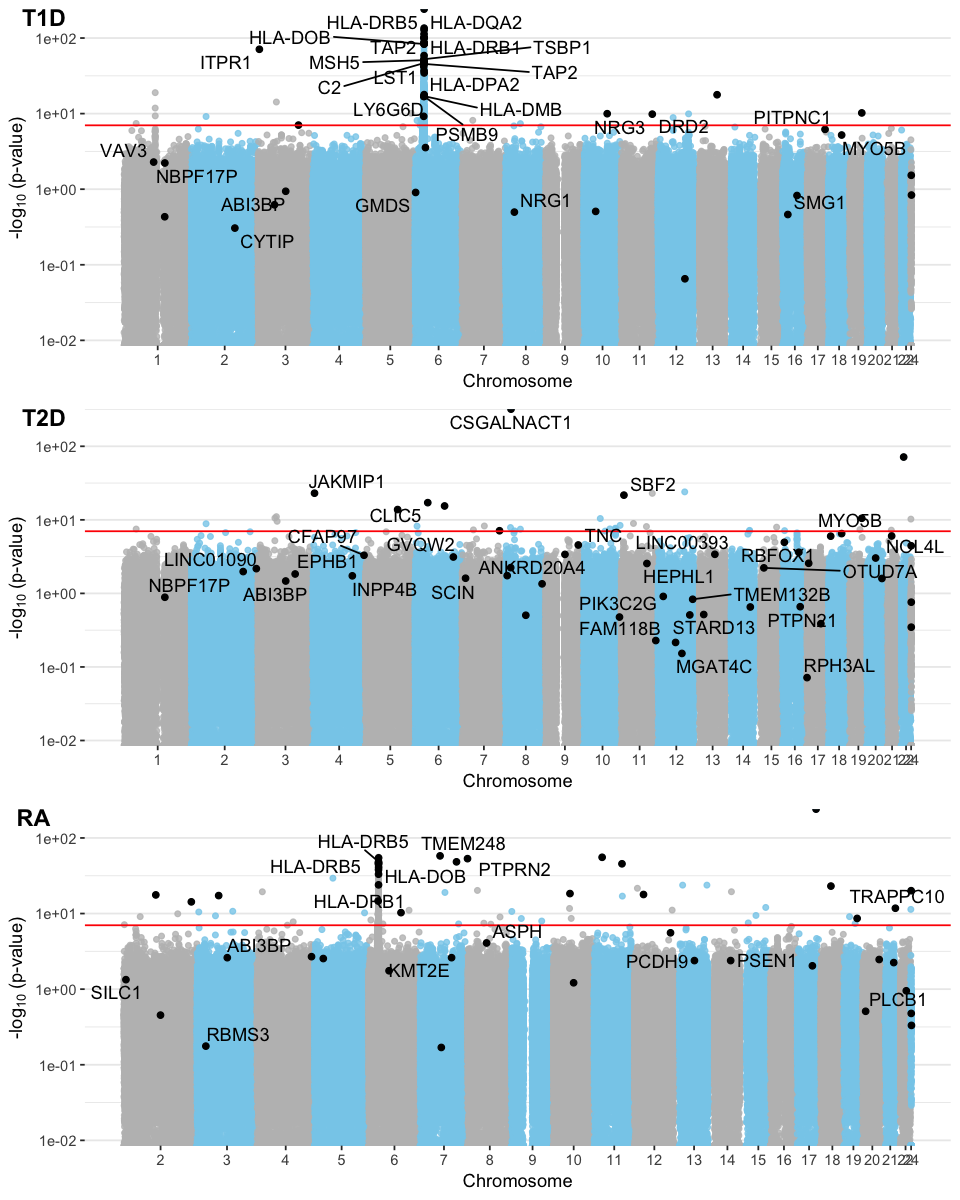

In [5]:
options(repr.plot.width=8, repr.plot.height=10)
plot_grid(t1d_plt, t2d_plt, ra_plt, nrow = 3,
          labels = c('T1D', 'T2D', 'RA'))